# Poission-Gaussian noise

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import pickle
import glob
import cloudpickle
import git
import numpy as np
import pandas as pd

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import ccutils

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

tmpdir = f'{homedir}/tmp/'
figdir = f'{homedir}/fig/moment_dynamics_numeric/'
datadir = f'{homedir}/data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Re}{\bb{R}_m'}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## Poisson-Gaussian noise for microscopy

In this notebook we will explore a probabilistic model to account for the experimental noise in the images we obtained with fluorescent microscopy. Specifically we will explore a mixture model known as the Poission-Gaussian model. This is a common model in the literature used to account for three types of noise:
1. Dark noise: Electronic noise in the reader due to thermal noise.
2. Shot noise: Randomness in the number of detected photons sensed at a given exposure level.
3. Readout noise: Noise generated during the conversion of charges into voltages.
In this model a readout $\nu$ is given by
$$
\nu = \alpha x + n,
$$
where $x \sim \text{Poisson}(\lambda)$ is a Poisson random variable, $\alpha$ is a gain constant that sets how much the shot noise affects the measurements, and $n \sim \mathcal{N}(0, \sigma^2)$ is a normally distributed random variable that accounts for the readout noise. In this sense a given readout $\nu$ has a probability
$$
P(\nu) = \sum_{x=0}^\infty P(\nu \mid x) P(x),
$$
where $P(x)$ is the Poisson probability mass function, i.e.
$$
P(x) = {\lambda^x e^{-\lambda} \over x!},
$$
and $P(\nu \mid x)$ is the Gaussian probability density function, i.e.
$$
P(\nu \mid x) = {1 \over \sqrt{2 \pi \sigma^2}} 
                e^{-{(\nu - \alpha x)^2 \over 2 \sigma^2}}.
$$

Putting this together then results in
$$
P(\nu) = \sum_{x=0}^\infty 
    {\lambda^x e^{-\lambda} \over x!}
    {1 \over \sqrt{2 \pi \sigma^2}} 
                e^{-{(\nu - \alpha x)^2 \over 2 \sigma^2}}.
$$

### Applying this noise model to single-cell reads.

For our particular case in which we determine the intensity of a single-cell we will assume that the intensity we measure $\nu$ depends on the number of proteins in the cell, such that for a given readout we have
$$
P(\nu) = \sum_{p = 0}^\infty P(\nu \mid p)P(p),
$$
where we take the sum over all possible protein copy numbers. If we include the Poisson-Gaussian noise we just covered, then this becomes
$$
P(\nu) = \sum_{p = 0}^\infty \sum_{x=0}^\infty 
         P(\nu \mid x, p) P(x \mid p) P(p),
$$
where we now condition the shot noise on the number of proteins $P(x \mid p)$.

## Computing the moments of the Poission-Gaussian distribution

The objective of this notebook is to systematically compute the moment sof the distribution using `sympy`'s engine in order to handle the messy algebra. At the end of the day we want to explore if this model can explain the discrepancy that we see at the level of the noise (std/mean) and skewness of gene expression.

We will not ask `sympy` to compute the sums and obtain the moments themselves since that would take a lot of effort. We will simply use our knowledge of the distribution moments and just use sympy to simplify things.

Let's define the necessary variables

In [3]:
# Define variables
nu, x, = sympy.symbols('\\nu x')
# Define parameters
alpha, sigma_2, lam = sympy.symbols('\\alpha \\sigma^2 \\lambda')
# Define protein moments
p1 = sympy.Symbol('\\left\\langle p \\right\\rangle')
p2 = sympy.Symbol('\\left\\langle p^2 \\right\\rangle')
p3 = sympy.Symbol('\\left\\langle p^3 \\right\\rangle')

n1 = sympy.Symbol('\\left\\langle \\nu \\right\\rangle')
n2 = sympy.Symbol('\\left\\langle \\nu^2 \\right\\rangle')
n3 = sympy.Symbol('\\left\\langle \\nu^3 \\right\\rangle')


nu, x, alpha, sigma_2, lam, p1, p2, p3, n1, n2, n3

#### Mean $\ee{\nu}$

To compute the first moment we have
$$
\ee{\nu} = \int_{-\infty}^{\infty} d\nu \; \nu P(\nu).
$$
Substituting $P(\nu)$ gives
$$
\ee{\nu} =
\int_{-\infty}^{\infty} d\nu \; \nu
\sum_{p = 0}^\infty \sum_{x=0}^\infty 
P(\nu \mid x, p) P(x \mid p) P(p).
$$
By rearranging the sums and the integral we can write
$$
\ee{\nu} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\int_{-\infty}^{\infty} d\nu \; \nu P(\nu \mid x, p).
$$
The term inside the integral is the expected value $\ee{\nu \mid x, p}$ which given our definition of this conditional distribution is the mean 
$$
\int_{-\infty}^{\infty} d\nu \; \nu P(\nu \mid x, p) = \alpha x.
$$

Substituting this result gives
$$
\ee{\nu} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\; \alpha x
$$
The internal sum is again the expected value $\ee{x \mid p} = \lambda p$ given that we have $p$ proteins that emit on average $\lambda$ photons. Using again this result gives
$$
\ee{\nu} =
\sum_{p = 0}^\infty P(p)
\; \alpha \lambda p.
$$
Finally this sum is just the expected value of the number of proteins. Therefore we have that the mean intensity $\ee{\nu}$ is of the form
$$
\ee{\nu} = \alpha \lambda \ee{p}.
$$

Let's define this mean in `sympy`.

In [4]:
nu_first = alpha * lam * p1
sympy.Eq(n1, nu_first)

#### Second moment $\ee{\nu^2}$

For the second moment we can follow a similar procedure. First we define the integral we need to compute
$$
\ee{\nu^2} = \int_{-\infty}^{\infty} d\nu \; \nu^2 P(\nu).
$$
Substituting $P(\nu)$ gives
$$
\ee{\nu^2} =
\int_{-\infty}^{\infty} d\nu \; \nu^2
\sum_{p = 0}^\infty \sum_{x=0}^\infty 
P(\nu \mid x, p) P(x \mid p) P(p).
$$
By rearranging the sums and the integral we can write
$$
\ee{\nu^2} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\int_{-\infty}^{\infty} d\nu \; \nu^2 P(\nu \mid x, p).
$$
The term inside the integral is the expected value $\ee{\nu^2 \mid x, p}$ which given our definition of this conditional distribution is the variance + mean squared,
$$
\int_{-\infty}^{\infty} d\nu \; \nu^2 P(\nu \mid x, p) = 
\sigma^2 + (\alpha x)^2.
$$

Substituting this result gives
$$
\ee{\nu^2} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\; \sigma^2 + \alpha^2 x^2
$$
Distributing the internal sum results in
$$
\ee{\nu^2} =
\sum_{p = 0}^\infty P(p)
\left[
\sigma^2 \sum_{x=0}^\infty P(x \mid p) + 
\alpha^2 \sum_{x=0}^\infty x^2 P(x \mid p)
\right].
$$
The first sum inside the brackets is just the normalization, i.e.
$$
\sum_{x=0}^\infty P(x \mid p) = 1.
$$
The second sum is the 2nd moment of a Poisson distribution. This can be sown to be equal to $(\lambda p)^2 + \lambda p$. So we have
$$
\sum_{x=0}^\infty x^2 P(x \mid p) = (\lambda p)^2 + \lambda p.
$$
Substituting these results gives
$$
\ee{\nu^2} =
\sum_{p = 0}^\infty P(p)
\left[
\sigma^2 + 
\alpha^2 \lambda^2 p^2 + \alpha^2 \lambda p
\right].
$$

Taking the sum over all values of $p$ results in
$$
\ee{\nu^2} = \sigma^2 + 
\alpha^2 \lambda^2 \ee{p^2} + 
\alpha^2 \lambda \ee{p}.
$$
Let's define this in sympy.

In [5]:
# Define second moment
nu_second = sigma_2 + alpha**2 * lam**2 * p2 + alpha**2 * lam * p1
sympy.Eq(n2, nu_second)

The variance is then given by

In [6]:
# Compute variance
nu_var = nu_second - nu_first**2
sympy.Eq(n2 - n1**2, nu_var.simplify())

And the noise squared (var / mean$^2$) takes the form

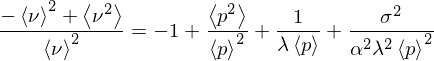

In [7]:
nu_noise_2 = nu_var / nu_first**2
sympy.Eq((n2 - n1**2) / n1**2, nu_noise_2.simplify())

For our expected range of $\lambda$ and $\ee{p}$ we can assume that the third term in the sum can be neglected. This then results

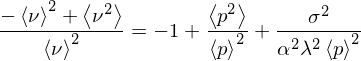

In [8]:
args = nu_noise_2.simplify().args
args = [x for i, x in enumerate(args) if i != 2]
nu_noise_approx = sum(args)
sympy.Eq((n2 - n1**2) / n1**2, nu_noise_approx)

Experimentally we have determined that this noise is 3 times larger than what the theory predicts. Let's solve for the model parameters given this condition. First we set the equation.

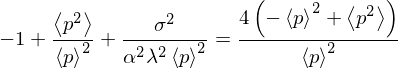

In [9]:
# Define theoretical noise
p_noise_2 = (p2 - p1**2) / p1**2

# Set equation
noise_eq = sympy.Eq(nu_noise_approx, 4 * p_noise_2)
noise_eq

Now let's try to solve for the parameters $\sigma^2 / \alpha^2 \lambda^2$

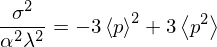

In [10]:
# Solve equation for parameters
noise_sol = sympy.solve(noise_eq, sigma_2 / alpha**2 / lam**2)
sympy.Eq(sigma_2 / (alpha**2 * lam**2), noise_sol[0])

#### Third moment $\ee{\nu^3}$

The third moment is the really tricky one algebraically. first just as with the previous moments we begin defining the integral to be computed.
$$
\ee{\nu^3} = \int_{-\infty}^{\infty} d\nu \; \nu^3 P(\nu).
$$
Substituting $P(\nu)$ gives
$$
\ee{\nu^3} =
\int_{-\infty}^{\infty} d\nu \; \nu^3
\sum_{p = 0}^\infty \sum_{x=0}^\infty 
P(\nu \mid x, p) P(x \mid p) P(p).
$$
By rearranging the sums and the integral we can write
$$
\ee{\nu^3} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\int_{-\infty}^{\infty} d\nu \; \nu^3 P(\nu \mid x, p).
$$
The term inside the integral is the expected value $\ee{\nu^3 \mid x, p}$ which given our definition of this conditional distribution is of the form
$$
\int_{-\infty}^{\infty} d\nu \; \nu^3 P(\nu \mid x, p) = 
(\alpha x)^3 + 3 (\alpha x) \sigma^2,
$$
i.e. the third moment of a Gaussian distribution.

Substituting this result gives
$$
\ee{\nu^3} =
\sum_{p = 0}^\infty P(p)
\sum_{x = 0}^\infty P(x \mid p)
\left[
\; (\alpha x)^3 + 3 (\alpha x) \sigma^2
\right]
$$
Distributing the internal sum results in
$$
\ee{\nu^3} =
\sum_{p = 0}^\infty P(p)
\left[
\alpha^3 \sum_{x=0}^\infty x^3 P(x \mid p) + 
3 \alpha \sigma^2 \sum_{x=0}^\infty x P(x \mid p)
\right].
$$
The first sum inside the brackets is the third moment of a Poisson distribution given by
$$
\sum_{x=0}^\infty x^3 P(x \mid p) = 
(\lambda p)^3 + 3(\lambda p)^2 + (\lambda p).
$$
The second sum is the mean of a Poisson distribution. So we have
$$
\sum_{x=0}^\infty x P(x \mid p) = \lambda p.
$$
Substituting these results gives
$$
\ee{\nu^3} =
\sum_{p = 0}^\infty P(p)
\left[
\alpha^3 \left( (\lambda p)^3 + 3(\lambda p)^2 + (\lambda p) \right) +
3 \alpha \sigma^2 \left( \lambda p \right)
\right].
$$
Finally we take the sum over all values of $p$, obtaining
$$
\ee{\nu^3} =
\alpha^3 
\left( 
\lambda^3 \ee{p^3} + 
3 \lambda^2 \ee{p}^2 + \lambda \ee{p}
\right) +
3 \alpha \sigma^2 \lambda \ee{p}.
$$
Let's define this in sympy.

In [11]:
nu_third = alpha**3 * (lam**3 * p3 + 3 * lam**2 * p2 + lam * p1) +\
           3 * alpha * sigma_2 * lam * p1
sympy.Eq(n3, nu_third)

With this in hand we can now compute the skewness of the distribution. The skewness $S(\nu)$ defined in terms of other moments is given by
$$
S(\nu) = {\ee{\nu ^3} - 3 \ee{\nu} \text{Var}(\nu) - \ee{\nu}^3 \over
          \text{Var}(\nu)^{3/2}}.
$$
Let's now compute this with `sympy`. This is the real reason we used this notebook because the algebra can get really messy.

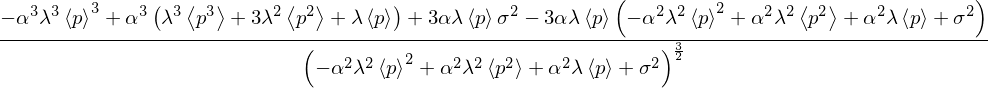

In [12]:
# Define skewness
nu_skew = (nu_third - 3 * nu_first * nu_var - nu_first**3) / \
          nu_var**(sympy.Rational(3, 2))
nu_skew

Again by experimental evidence we know that this skewness is twice as large as the theoretical prediction. Let's see if we can infer anything from this.

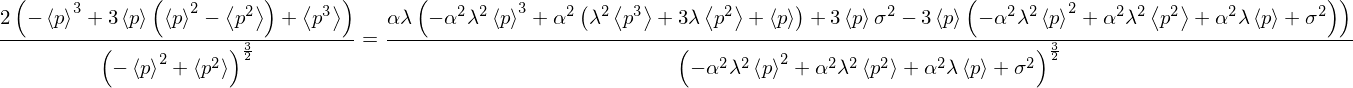

In [13]:
# Define protein skewness
p_skew = (p3 - 3 * p1 * (p2 - p1**2) - p1**3) /\
         (p2 - p1**2)**(sympy.Rational(3, 2))
          
skew_eq = sympy.Eq(nu_skew, 2 * p_skew)
skew_eq.simplify()

There is nothing crystal clear here. Let's try a different approach

## "Experimental mathematics" with moments

From the realm of what we would call experimental mathematics we can see that our numerical integrations of the moment equations have an interesting relationship between the moments of the protein distribution. Specifically we can express both the second moment $\ee{p^2}$ and the third moment $\ee{p^3}$ as simple functions of the first moment. Specifically we can show that to a very good approximation
$$
\ee{p^2} \approx \ee{p}^2 + m_{21},
$$
where $m_{21}$ is an intercept done when performing a linear regression between $\ee{p}^2$ and $\ee{p^2}$. The slope of this regression is really close to 1, that's why we approximate it to be 1. The same is true when performing a linear regression between $\ee{p}^3$ and $\ee{p^3}$, so we approximate this moment as
$$
\ee{p^3} \approx \ee{p}^3 + m_{31},
$$

Using these substitutions let's see if we find something interesting. First let's look at the noise. For this we will substitute our previous results with these approximations for the moments.

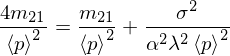

In [58]:
# Define linear regression variables
m21, m31 = sympy.symbols('m_{21} m_{31}')

nu_noise_subs = nu_noise_approx.subs(
    {p2: p1**2 + m21, p3: p1**3 + m31}
)
p_noise_subs = p_noise_2.subs(
    {p2: p1**2 + m21, p3: p1**3 + m31}
)

noise_eq = sympy.Eq(nu_noise_subs, 4 * p_noise_subs)
noise_eq.simplify()

Now we can solve for the parameters of our Poisson-Gaussian model

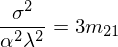

In [59]:
sympy.Eq(
    sigma_2 / alpha**2 / lam**2,
    sympy.solve(noise_eq, sigma_2 / alpha**2 / lam**2)[0]
        )

This is quite interesting. What this says is that in order to account for the factor of 4 difference in our noise squared (var / mean$^2$), a constant set of parameters equivalent to 3 times the intercept that relates $\ee{p^2}$ and $\ee{p}$ would solve the issue.

Let's repeat this with the skewness.

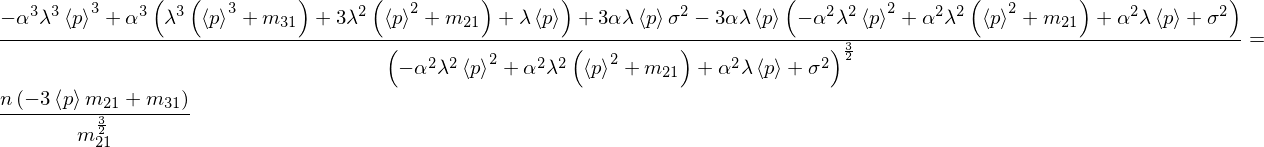

In [61]:
# Define factor between experimental and theoretical skewness as variable
n = sympy.Symbol('n')
# Substitute approximation of moments
nu_skew_subs =  nu_skew.subs({p2: p1**2 + m21, p3: p1**3 + m31})
p_skew_subs = p_skew.subs({p2: p1**2 + m21, p3: p1**3 + m31})

skew_eq = sympy.Eq(nu_skew_subs, n * p_skew_subs)

skew_eq

Now let's substitute $\sigma^2$ as a function of the other parameters.

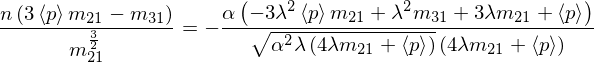

In [67]:
skew_eq_subs = skew_eq.subs(
    {sigma_2 : 3 * m21 * alpha**2 * lam**2}
).simplify()
skew_eq_subs

Now let's see if we can solve for $n$ and obtain what we would expect.

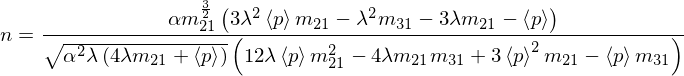

In [71]:
sympy.Eq(n, sympy.solve(skew_eq_subs, n)[0])

Not really. This is a function of $\ee{p}$